Automatically created module for IPython interactive environment


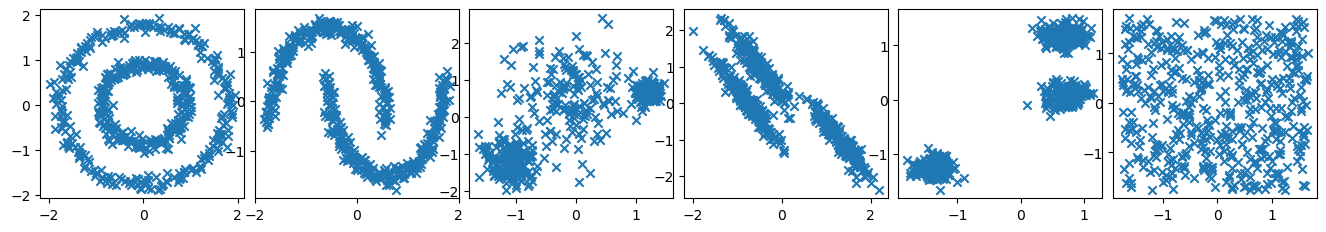

In [1]:
import time
import warnings
import collections
import numpy as np
import matplotlib.pyplot as plt
import queue
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice



print(__doc__)


np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(20,4))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.95, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2,
                     'min_samples': 20, 'xi': 0.25}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2,
              'min_samples': 5, 'xi': 0.035, 'min_cluster_size': .2}),
    (aniso, {'eps': .15, 'n_neighbors': 2,
             'min_samples': 20, 'xi': 0.1, 'min_cluster_size': .2}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)
    plt.subplot(len(dataset), len(params), plot_num)
    plt.scatter(X[:,0],X[:,1],marker='x')
    plt.show
    plot_num+=1

# dataset,algo_params=(datasets[1])
# X,y=(dataset)
# X=StandardScaler().fit_transform(X)
# plt.scatter(X[:,0],X[:,1],marker='x')
# plt.show()  

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import datasets


class SVMPrimalProblem:
    def __init__(self, C=1.0, kernel='rbf', sigma=.1, degree=2):

        if kernel == 'poly':
            self.kernel = self._polynomial_kernel
            self.c = 1
            self.degree = degree
        else:
            self.kernel = self._rbf_kernel
            self.sigma = sigma

        self._support_vectors = None
        self.C = C
        self.w = None
        self.b = None
        self.X = None
        self.y = None
        self.K = None

    def _rbf_kernel(self, X1, X2):
        return np.exp(-(1 / self.sigma ** 2) * np.linalg.norm(X1[:, np.newaxis] - X2[np.newaxis, :], axis=2) ** 2)

    def _polynomial_kernel(self, X1, X2):
        return (self.c + X1.dot(X2.T)) ** self.degree

    def __decision_function(self, X):
        return self.w.dot(self.kernel(self.X, X)) + self.b

    def __margin(self, X, y):
        return y * self.__decision_function(X)

    def fit(self, X, y, lr=1e-5, epochs=500):
        # Initialize Beta and b
        self.w = np.random.randn(X.shape[0])
        self.b = 0

        self.X = X
        self.y = y
        # Kernel Matrix
        self.K = self.kernel(X, X)

        loss_array = []
        for _ in range(epochs):
            margin = self.__margin(X, y)

            misclassified_pts_idx = np.where(margin < 1)[0]
            d_w = self.K.dot(self.w) - self.C * y[misclassified_pts_idx].dot(self.K[misclassified_pts_idx])
            self.w = self.w - lr * d_w

            d_b = - self.C * np.sum(y[misclassified_pts_idx])
            self.b = self.b - lr * d_b

            loss = (1 / 2) * self.w.dot(self.K.dot(self.w)) + self.C * np.sum(np.maximum(0, 1 - margin))
            loss_array.append(loss)

        self._support_vectors = np.where(self.__margin(X, y) <= 1)[0]

        plt.plot(loss_array)
        plt.title("loss per epochs")
        plt.show()

    def predict(self, X):
        return np.sign(self.__decision_function(X))

    def score(self, X, y):
        prediction = self.predict(X)
        return np.mean(y == prediction)

    def plot_decision_boundary(self):
        plt.scatter(self.X[:, 0], self.X[:, 1], c=self.y, s=50, cmap=plt.cm.Paired, alpha=.7)
        ax = plt.gca()
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()

        # create grid to evaluate model
        xx = np.linspace(xlim[0], xlim[1], 30)
        yy = np.linspace(ylim[0], ylim[1], 30)
        YY, XX = np.meshgrid(yy, xx)
        xy = np.vstack([XX.ravel(), YY.ravel()]).T
        Z = self.__decision_function(xy).reshape(XX.shape)

        # plot decision boundary and margins
        ax.contour(XX, YY, Z, colors=['b', 'g', 'r'], levels=[-1, 0, 1], alpha=0.5,
                   linestyles=['--', '-', '--'], linewidths=[2.0, 2.0, 2.0])

        # highlight the support vectors
        ax.scatter(self.X[:, 0][self._support_vectors], self.X[:, 1][self._support_vectors], s=100,
                   linewidth=1, facecolors='none', edgecolors='k')

        plt.show()


def load_data(cols):
    iris = sns.load_dataset("iris")
    iris = iris.tail(100)

    le = preprocessing.LabelEncoder()
    y = le.fit_transform(iris["species"])

    X = iris.drop(["species"], axis=1)

    if len(cols) > 0:
        X = X[cols]

    return X.values, y

In [3]:
class SampleData:
    def get_moon(self, n_samples, noise=0.05):
        noisy_moons = datasets.make_moons(n_samples=n_samples, noise=noise, random_state=42)
        return noisy_moons[0], noisy_moons[1]

    def get_donut(self, n_samples, noise=0.05, factor=0.5):
        noisy_circles = datasets.make_circles(n_samples=n_samples, factor=factor, noise=noise, random_state=2)
        return noisy_circles[0], noisy_circles[1]

    def plot(self, X, y):
        ax = plt.gca()
        ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
        plt.show()

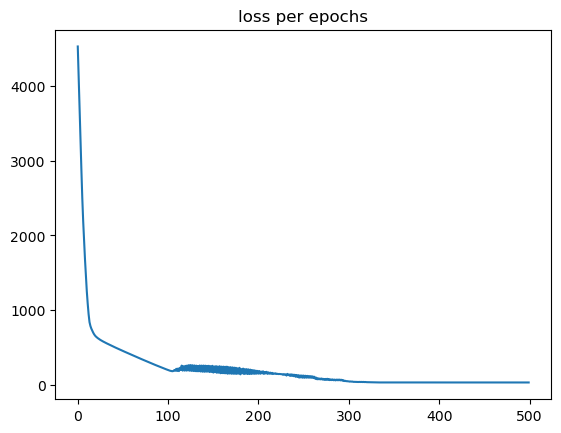

train score: 1.0


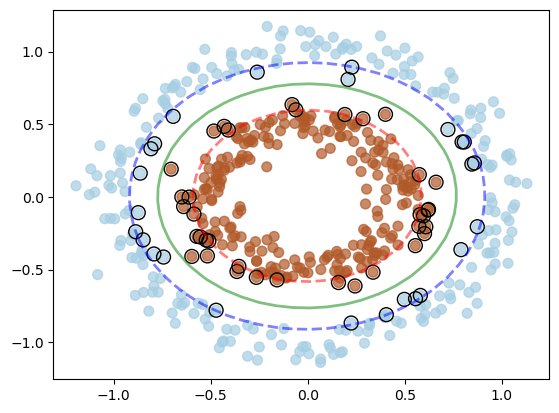

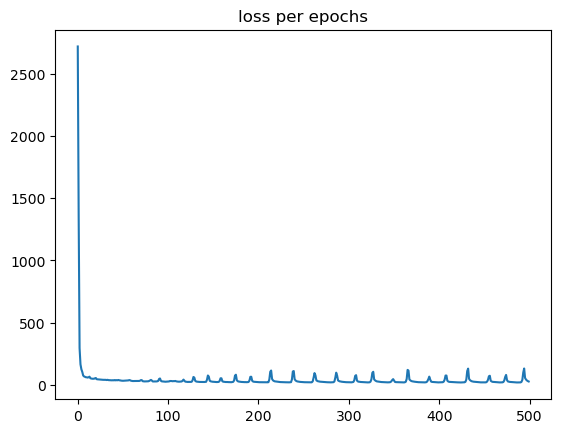

train score: 1.0


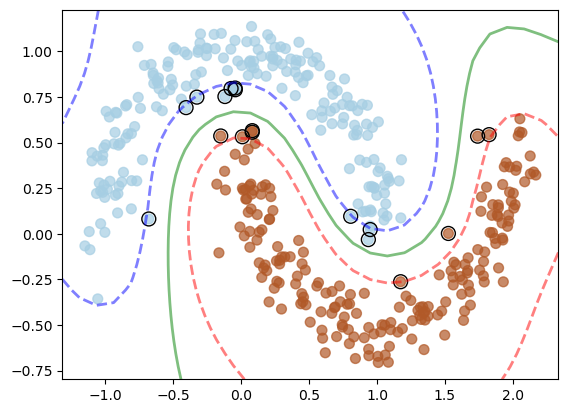

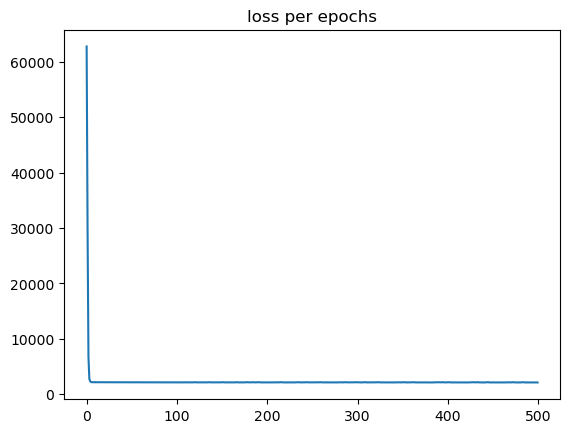

train score: 0.94


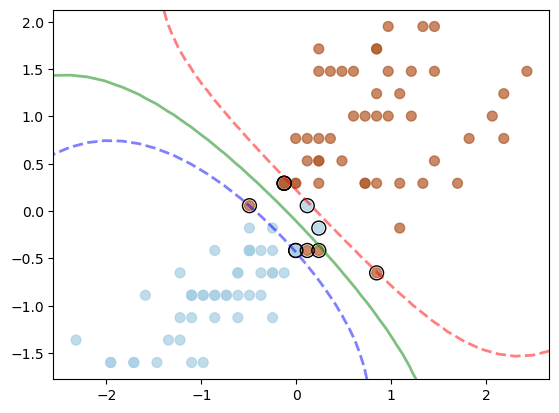

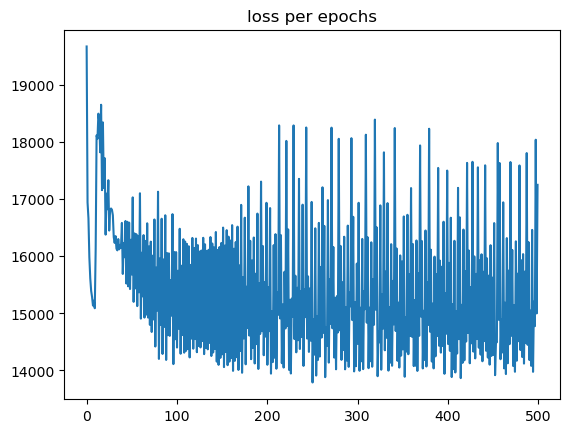

train score: 0.72


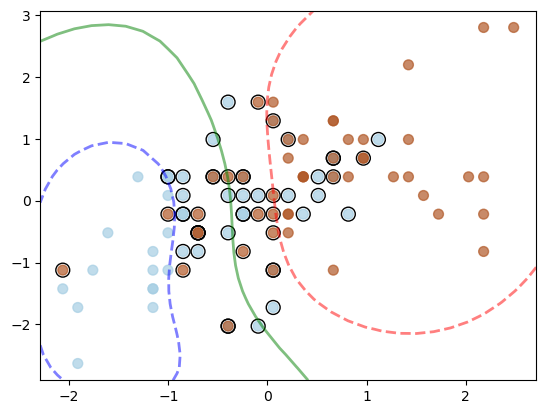

In [4]:

if __name__ == '__main__':
    sample = SampleData()
    X, y = sample.get_donut(n_samples=500, noise=0.08)
    y[y == 0] = -1

    svm = SVMPrimalProblem(C=1.0, kernel='poly', degree=2)
    svm.fit(X, y, lr=1e-5, epochs=500)
    print("train score:", svm.score(X, y))
    svm.plot_decision_boundary()

    X, y = sample.get_moon(n_samples=400, noise=0.1)
    y[y == 0] = -1

    svm = SVMPrimalProblem(C=1.0, kernel='rbf', sigma=.7)
    svm.fit(X, y, lr=1e-3)
    print("train score:", svm.score(X, y))
    svm.plot_decision_boundary()

    # make sure the targets are (-1, +1)
    cols = ["petal_length", "petal_width"]
    X, y = load_data(cols)

    y[y == 0] = -1

    # scale the data
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    # now we'll use our custom implementation
    model = SVMPrimalProblem(C=200.0, kernel='rbf', sigma=2.0)

    model.fit(X, y, lr=1e-5)
    print("train score:", model.score(X, y))
    model.plot_decision_boundary()

    cols = ["sepal_length", "sepal_width"]
    X, y = load_data(cols)

    y[y == 0] = -1

    # scale the data
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    # now we'll use our custom implementation
    model = SVMPrimalProblem(C=200.0, kernel='rbf', sigma=2.0)

    model.fit(X, y, lr=1e-5)
    print("train score:", model.score(X, y))
    model.plot_decision_boundary()    